In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

# 1. Analyse the darkness content of UniRef50 and AlphaFold DB (v4)

### 1.1. Load data
First, run:

`python3 scripts/AFDBv4_pLDDT_analysis.py UniRef50`

This will generate the file `data_generated/AFDBv4_pLDDT_diggestion.csv`. The corresponding for the AFDB90v4 paper, is `data_generated/AFDBv4_pLDDT_diggestion_UniRef50_2023-02-01.csv`, which we load in the next cell.

This file contains the per UniRef50 cluster data on functional darkness, cluster size, median evidence score for the proteins contained, and pLDDT distributions in the AlphaFold database if there is at least one member of the cluster in AFDB. This table refers to ALL Uniref50 clusters and not only those with members in AFDB. 

The column corresponding to functional darkness is "FULL_noDUF", which reads "full annotation coverage, excluding DUFs and related terms".

In [2]:
indata = 'data_generated_v2/AFDBv4_pLDDT_diggestion_UniRef50_2023-02-01.csv'
indata = pd.read_csv(indata)
indata = indata.sort_values(by='unirefID')
indata = indata.set_index("unirefID")
indata = indata[:-1]
indata

/scicore/home/schwede/soares0000/projects/dark_protein_universe/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AF2_REP_best,AF2_REP_best_len,AF2_REP_worst,AF2_REP_worst_len,AF2_longest_best70,AF2_longest_best70_len,AF2_longest_best70_pLDDT,FULL_noDUF,REP,SP,TM,delta_pLDDT,max_pLDDT,median_Evidence,median_pLDDT,min_pLDDT,nACCs,nAF2,nUniRef100,nUniRef90
unirefID,,,,,,,,,,,,,,,,,,,,
UniRef50_A0A007,A0A007,407.0,NaN,NaN,A0A007,407.0,88.248698,96.81,A0A007,0,0,0.000000,88.248698,4.0,88.248698,88.248698,1,1,1,1
UniRef50_A0A009DWD5,A0A009DWD5,39.0,NaN,NaN,A0A009DWD5,39.0,71.991282,0.00,NaN,0,0,0.000000,71.991282,4.0,71.991282,71.991282,1,1,1,1
UniRef50_A0A009DWJ5,A0A009DWJ5,47.0,NaN,NaN,A0A009DWJ5,47.0,80.863404,80.85,A0A009DWJ5,0,0,0.000000,80.863404,4.0,80.863404,80.863404,1,1,1,1
UniRef50_A0A009DWL0,A0A009DWL0,76.0,NaN,NaN,NaN,NaN,NaN,98.67,UPI0018888667,0,0,0.000000,52.397763,4.0,52.397763,52.397763,3,1,3,3
UniRef50_A0A009DY31,A0A2D5KFP4,46.0,A0A0K6IRR6,57.0,A0A009DY31,48.0,70.708333,93.75,A0A009DY31,0,0,-23.334962,83.109348,4.0,76.051401,59.774386,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UniRef50_Z9JYV3,Z9JYV3,151.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0,0,0.000000,64.583444,4.0,64.583444,64.583444,1,1,1,1
UniRef50_Z9JYV5,Z9JYV5,211.0,NaN,NaN,NaN,NaN,NaN,99.53,Z9JYV5,0,0,0.000000,45.124692,4.0,45.124692,45.124692,1,1,1,1
UniRef50_Z9JYW2,Z9JYW2,261.0,NaN,NaN,Z9JYW2,261.0,73.070268,99.62,Z9JYW2,0,0,0.000000,73.070268,4.0,73.070268,73.070268,1,1,1,1


In [7]:
indata['darkness_bins'] = pd.cut(indata['FULL_noDUF'].astype(float), bins=[i for i in range(0, 105, 5)], include_lowest=True)
indata['median_Evidence'] = indata['median_Evidence'].fillna(0)
indata

,AF2_REP_best,AF2_REP_best_len,AF2_REP_worst,AF2_REP_worst_len,AF2_longest_best70,AF2_longest_best70_len,AF2_longest_best70_pLDDT,FULL_noDUF,REP,SP,...,delta_pLDDT,max_pLDDT,median_Evidence,median_pLDDT,min_pLDDT,nACCs,nAF2,nUniRef100,nUniRef90,darkness_bins
unirefID,,,,,,,,,,,,,,,,,,,,,
UniRef50_A0A007,A0A007,407.0,NaN,NaN,A0A007,407.0,88.248698,96.81,A0A007,0,...,0.000000,88.248698,4.0,88.248698,88.248698,1,1,1,1,"(95.0, 100.0]"
UniRef50_A0A009DWD5,A0A009DWD5,39.0,NaN,NaN,A0A009DWD5,39.0,71.991282,0.00,NaN,0,...,0.000000,71.991282,4.0,71.991282,71.991282,1,1,1,1,"(-0.001, 5.0]"
UniRef50_A0A009DWJ5,A0A009DWJ5,47.0,NaN,NaN,A0A009DWJ5,47.0,80.863404,80.85,A0A009DWJ5,0,...,0.000000,80.863404,4.0,80.863404,80.863404,1,1,1,1,"(80.0, 85.0]"
UniRef50_A0A009DWL0,A0A009DWL0,76.0,NaN,NaN,NaN,NaN,NaN,98.67,UPI0018888667,0,...,0.000000,52.397763,4.0,52.397763,52.397763,3,1,3,3,"(95.0, 100.0]"
UniRef50_A0A009DY31,A0A2D5KFP4,46.0,A0A0K6IRR6,57.0,A0A009DY31,48.0,70.708333,93.75,A0A009DY31,0,...,-23.334962,83.109348,4.0,76.051401,59.774386,4,4,4,4,"(90.0, 95.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UniRef50_Z9JYV3,Z9JYV3,151.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0,...,0.000000,64.583444,4.0,64.583444,64.583444,1,1,1,1,"(-0.001, 5.0]"
UniRef50_Z9JYV5,Z9JYV5,211.0,NaN,NaN,NaN,NaN,NaN,99.53,Z9JYV5,0,...,0.000000,45.124692,4.0,45.124692,45.124692,1,1,1,1,"(95.0, 100.0]"
UniRef50_Z9JYW2,Z9JYW2,261.0,NaN,NaN,Z9JYW2,261.0,73.070268,99.62,Z9JYW2,0,...,0.000000,73.070268,4.0,73.070268,73.070268,1,1,1,1,"(95.0, 100.0]"


To add DUF counts into the dataframe, run `python3 scripts/AFDBv4_DUF_analysis_dark.py UniRef50`, which will generate the `generated_data/AFDBv4_DUF_dark_diggestion_UniRef50.csv`

For the AFDB90v4 paper, the precomupted file is `data_generated/AFDBv4_DUF_dark_diggestion_UniRef50_2023-02-06.csv`

This table list each UniRef50 cluster and states whether there are proteins annotated for DUFs in it. We want to merge this information into the dataframe above.

In [4]:
# get DUF distribution of all darks and merge with the data

duf_dark_data = 'data_generated_v2/AFDBv4_DUF_dark_diggestion_UniRef50_2023-02-06.csv'
duf_dark_data = pd.read_csv(duf_dark_data)
duf_dark_data = duf_dark_data.sort_values(by='unirefID')
duf_dark_data = duf_dark_data.set_index("unirefID")
duf_dark_data = duf_dark_data[:-1]

indata = pd.concat([indata, duf_dark_data], axis=1)
indata

,AF2_REP_best,AF2_REP_best_len,AF2_REP_worst,AF2_REP_worst_len,AF2_longest_best70,AF2_longest_best70_len,AF2_longest_best70_pLDDT,FULL_noDUF,REP,SP,...,max_pLDDT,median_Evidence,median_pLDDT,min_pLDDT,nACCs,nAF2,nUniRef100,nUniRef90,darkness_bins,Has_duf
UniRef50_A0A007,A0A007,407.0,NaN,NaN,A0A007,407.0,88.248698,96.81,A0A007,0,...,88.248698,4.0,88.248698,88.248698,1,1,1,1,"(95.0, 100.0]",NaN
UniRef50_A0A009DWD5,A0A009DWD5,39.0,NaN,NaN,A0A009DWD5,39.0,71.991282,0.00,NaN,0,...,71.991282,4.0,71.991282,71.991282,1,1,1,1,"(-0.001, 5.0]",0.0
UniRef50_A0A009DWJ5,A0A009DWJ5,47.0,NaN,NaN,A0A009DWJ5,47.0,80.863404,80.85,A0A009DWJ5,0,...,80.863404,4.0,80.863404,80.863404,1,1,1,1,"(80.0, 85.0]",NaN
UniRef50_A0A009DWL0,A0A009DWL0,76.0,NaN,NaN,NaN,NaN,NaN,98.67,UPI0018888667,0,...,52.397763,4.0,52.397763,52.397763,3,1,3,3,"(95.0, 100.0]",NaN
UniRef50_A0A009DY31,A0A2D5KFP4,46.0,A0A0K6IRR6,57.0,A0A009DY31,48.0,70.708333,93.75,A0A009DY31,0,...,83.109348,4.0,76.051401,59.774386,4,4,4,4,"(90.0, 95.0]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UniRef50_Z9JYV3,Z9JYV3,151.0,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0,...,64.583444,4.0,64.583444,64.583444,1,1,1,1,"(-0.001, 5.0]",NaN
UniRef50_Z9JYV5,Z9JYV5,211.0,NaN,NaN,NaN,NaN,NaN,99.53,Z9JYV5,0,...,45.124692,4.0,45.124692,45.124692,1,1,1,1,"(95.0, 100.0]",NaN
UniRef50_Z9JYW2,Z9JYW2,261.0,NaN,NaN,Z9JYW2,261.0,73.070268,99.62,Z9JYW2,0,...,73.070268,4.0,73.070268,73.070268,1,1,1,1,"(95.0, 100.0]",NaN
UniRef50_Z9JYW9,Z9JYW9,171.0,NaN,NaN,NaN,NaN,NaN,78.36,Z9JYW9,0,...,34.725965,4.0,34.725965,34.725965,1,1,1,1,"(75.0, 80.0]",NaN


## 1.2. Make histogram at different pLDDT cutoffs

Full n = 53625854 n_dark = 18249414 uniprot_n_dark = 37761108.0 % uniprot = 10.308197827140427
Full n = 53625854 n_dark = 18249414 uniref100_n_dark = 33852950.0 % uniref100 = 10.767738572191368
% UniRef50 dark with dufs = 0.08570847130870293

AFDB n = 41983663 n_dark = 12339265 uniprot_n_dark = 29763470.0 % uniprot = 8.614381123145668
AFDB n = 41983663 n_dark = 12339265 uniref100_n_dark = 26286720.0 % uniref100 = 8.887961218741369
% UniRef50 dark with dufs = 0.10342012509280826

AFDB70 n = 26228839 n_dark = 5618293 uniprot_n_dark = 19979438.0 % uniprot = 6.4303307109762855
AFDB70 n = 26228839 n_dark = 5618293 uniref100_n_dark = 17307646.0 % uniref100 = 6.5541442844322315
% UniRef50 dark with dufs = 0.18025675909453015

AFDB90 n = 6136321 n_dark = 927430 uniprot_n_dark = 3696194.0 % uniprot = 6.043489091347138
AFDB90 n = 6136321 n_dark = 927430 uniref100_n_dark = 3275219.0 % uniref100 = 6.180251211639788
% UniRef50 dark with dufs = 0.06771225311444018



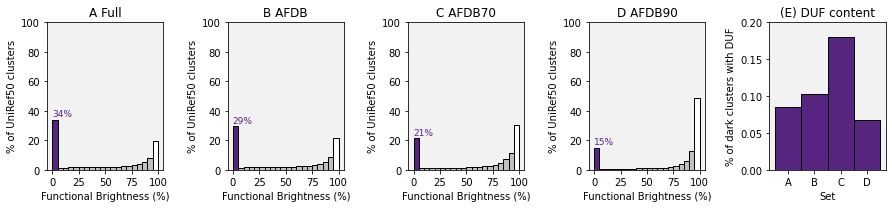

In [5]:
modes = ['Full', 'AFDB', 'AFDB70', 'AFDB90']
panel = ['A', 'B', 'C', 'D', 'E']

fig, ax = plt.subplots(1, len(panel), figsize=(2.5*len(panel), 3))
percentage_dufs = []

for j, mode in enumerate(modes):
    if mode == 'Full':
        tmp = indata
    if 'AFDB' in mode:
        tmp = indata.loc[indata.nAF2.astype(float) > 0]
        if len(mode.split('AFDB')[-1]) > 0:
            cut = int(mode.split('AFDB')[-1])
            tmp = tmp.loc[tmp.AF2_longest_best70_pLDDT.astype(float) >= cut]
    
    h,_ = np.histogram(tmp.FULL_noDUF.astype(float), bins=[i for i in range(0, 105, 5)])
    n_dark = h[0]
    h = h*100/sum(h)

    colors = ['#57257F']
    for i in range(len(h)-2):
        colors.append('silver')
    colors.append('white')

    x = list(range(len(h)))
    y = list(h)

    ax[j].bar(x,y,1, align='edge', color=colors, edgecolor='k')
    ax[j].set_facecolor('#F2F2F2')
    ax[j].set_xticks(range(0,21,5))
    ax[j].set_xticklabels(range(0,101,25))
    ax[j].set_ylabel('% of UniRef50 clusters')
    ax[j].set_xlabel('Functional Brightness (%)')
    
    ax[j].title.set_text('{} {}'.format(panel[j], mode))

    ax[j].set_ylim(0,100)
    
    percentage_dark = round(h[0])
    ax[j].text(-0.1, percentage_dark+1, '{}%'.format(percentage_dark),
               verticalalignment='bottom', horizontalalignment='left',
               color='#57257F', fontsize=9)
    
    uniprot_n_dark = sum(tmp.loc[tmp.FULL_noDUF.astype(float) <=5].nACCs.astype(float))
    print(mode, 'n =', len(tmp), 'n_dark =', n_dark, 'uniprot_n_dark =', uniprot_n_dark, '% uniprot =', uniprot_n_dark*100/sum(tmp.nACCs.astype(float)))

    uniref_n_dark = sum(tmp.loc[tmp.FULL_noDUF.astype(float) <=5].nUniRef100.astype(float))
    print(mode, 'n =', len(tmp), 'n_dark =', n_dark, 'uniref100_n_dark =', uniref_n_dark, '% uniref100 =', uniref_n_dark*100/sum(tmp.nUniRef100.astype(float)))
    
    percentage_duf = len(tmp.loc[tmp.Has_duf == 1])*100/len(tmp.loc[tmp.FULL_noDUF.astype(float) <=5])
    print('% UniRef50 dark with dufs =', percentage_duf)
    print()
    
    percentage_dufs.append(percentage_duf)

ax[j+1].bar(panel[:-1],percentage_dufs,1, align='center', color=['#57257F' for i in modes], edgecolor='k')
ax[j+1].set_facecolor('#F2F2F2')
ax[j+1].set_ylabel('% of dark clusters with DUF')
ax[j+1].set_xlabel('Set')
ax[j+1].title.set_text('({}) DUF content'.format(panel[j+1]))
ax[j+1].set_ylim(0,0.2)
    
plt.tight_layout()
plt.savefig('plots/AFDBv4_uniref50_histogram_dark_content.pdf')
plt.savefig('plots/AFDBv4_uniref50_histogram_dark_content.png', dpi=2000)

In [6]:
print('brightness vs size Correlation {}:'.format(mode), scipy.stats.pearsonr(indata['FULL_noDUF'], indata['nUniRef100'])[1])

brightness vs size Correlation AFDB90: 0.0


In [7]:
indata.groupby(['darkness_bins'])['nUniRef100'].agg([np.mean, np.std, np.median])

,mean,std,median
darkness_bins,,,
"(-0.001, 5.0]",1.854932,7.471334,1
"(5.0, 10.0]",3.238855,18.929983,1
"(10.0, 15.0]",3.051652,16.244046,1
"(15.0, 20.0]",2.881375,15.197970,1
"(20.0, 25.0]",2.758930,15.388115,1
"(25.0, 30.0]",2.670532,13.003847,1
"(30.0, 35.0]",2.595750,11.021570,1
"(35.0, 40.0]",2.644472,12.318777,1
"(40.0, 45.0]",2.672398,11.483546,1


# 2. Define AFDB90 set and collect all associated sequences from previously contructed mongoDB

The AFDB90 set corresponds to those UniRef50 clusters where the longest member with a pLDDT >70% has a pLDDT >90%. We thus select only those from the table above and save them as a table and the corresponding fasta file. 

The table will be used for further analysis in the other jupyter notebooks. The fasta file will be used for the all-against-all mmseqs2 searches that make the base of the sequence similarity network.

In [8]:
AFDB90 = indata.loc[indata.AF2_longest_best70_pLDDT.astype(float) >= 90]
AFDB90.to_csv('data_generated_v2/AFDB90v4_data.csv')

In [ ]:
dbuilder_path = None # change accordingly

import sys
import os
sys.path.append(dbuilder_path)

import extract_uniprot     as uniprot

MONGO_HOST = "10.1.0.202"
MONGO_PORT = 30077

uniprot_db   = uniprot.uniprot_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT)

In [ ]:
outfasta = 'data_generated_v2/AFDBv4_90.fasta'

count = 0
step = 100000

target_ids =  [i.split('_')[1] for i in AFDB90.index]
n_entries = len(target_ids)

chuncks   = [target_ids[i:i+step] if i+step < len(target_ids) else target_ids[i:] for i in range(0, n_entries, step)]
collected_ids = []

print('Getting sequences for {} chuncks'.format(len(chuncks)))
      
with open(outfasta, 'w') as out:
    for i, chunck in enumerate(chuncks):
        documents = uniprot_db.col.find({'_id': {'$in': chunck}})
        for doc in documents:
            out.write('>{}\n{}\n'.format(doc['_id'], doc['data']['SEQ']))

    